<a href="https://colab.research.google.com/github/907Resident/pitch-sequence/blob/main/pitch_sequence_classification_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Baseball Events
Using pitch data, can we predict what pitch type will lead to specific events?

See [pitch-sequence repo](https://github.com/907Resident/pitch-sequence) for more details.

## Mount Google Drive 
This can be accomplished manually using the by clicking the file folder icon on the left or can be accomplished programmatically by executing the code in this cell

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [54]:
# Point toward pitch-sequence subdirectory
%cd /content/gdrive/My Drive/Colab Notebooks/pitch-sequence

/content/gdrive/My Drive/Colab Notebooks/pitch-sequence


### Import modules and data

In [51]:
# Import necessary libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing and ML Preparation
Import necessary modules, updates, data files, and organize data for heavier lifting in the subsequent sections

"clean_pitching_data.csv" was created in the EDA phase with another notebook in this project (pitch-sequence-SO.ipynb). It has been cleaned for this purpose but no feature engineering has been applied

### Import data


In [149]:
# Establish preferred data types
preferred_dtypes ={"start_speed":"float64", "end_speed":"float64", 
                   "code":"category", "pitch_type":"category", "outs":"int", 
                   "event":"category", "b_count":"category","s_count":"category", 
                   "p_score":"int", "pitch_num":"int", "inning":"int", 
                   "ab_id":"int64", "first_name":"str",
                   "last_name":"str"}
# Import data into workspace
df_main = pd.read_csv("clean_pitching_data.csv", dtype=preferred_dtypes)
# Confirm that "ab_id" is a string so that it does not show up in scientific
# notation
df_main["ab_id"] = df_main.ab_id.astype("int64").astype("str")
# Confirm "pitch_type" and "code" are categories
df_main["code"] = df_main.code.astype("category")
df_main["pitch_type"] = df_main.pitch_type.astype("category")
## From the EDA notebook, we knwo to drop three of the pitch types
relevant_pitch_types = ['CH', 'CU', 'FC', 'FF', 'FS', 'FT', 'KC', 
                        'SI', 'SL']
filter_mask = df_main.pitch_type.isin(relevant_pitch_types)
df_main = df_main.loc[filter_mask]
# Drop spin, confidence, and nasty columns
df_main.drop(columns=["nasty", "spin_dir", "spin_rate", "type_confidence"], 
             inplace=True)
# Preview dataframe
print(df_main.shape)
df_main.head()

(721876, 17)


,pitcher_id,first_name,last_name,start_speed,end_speed,code,pitch_type,b_score,ab_id,b_count,s_count,outs,pitch_num,inning,p_score,p_throws,event
0,571666,Mike,Fiers,88.8,80.7,X,FF,0.0,2019000001,0,0,0,1,1,0,R,Flyout
1,571666,Mike,Fiers,89.9,81.8,C,FF,0.0,2019000002,0,0,1,1,1,0,R,Flyout
2,571666,Mike,Fiers,85.7,79.6,S,SL,0.0,2019000002,0,0,1,2,1,0,R,Flyout
3,571666,Mike,Fiers,85.4,78.5,B,CH,0.0,2019000002,0,1,1,3,1,0,R,Flyout
4,571666,Mike,Fiers,84.6,77.6,B,CH,0.0,2019000002,1,1,1,4,1,0,R,Flyout


### Preprocess Data
In this section the cleaned data is processed into a format that is conducive for ML. 

Visualize the number of occurences for the target variable, `event`.

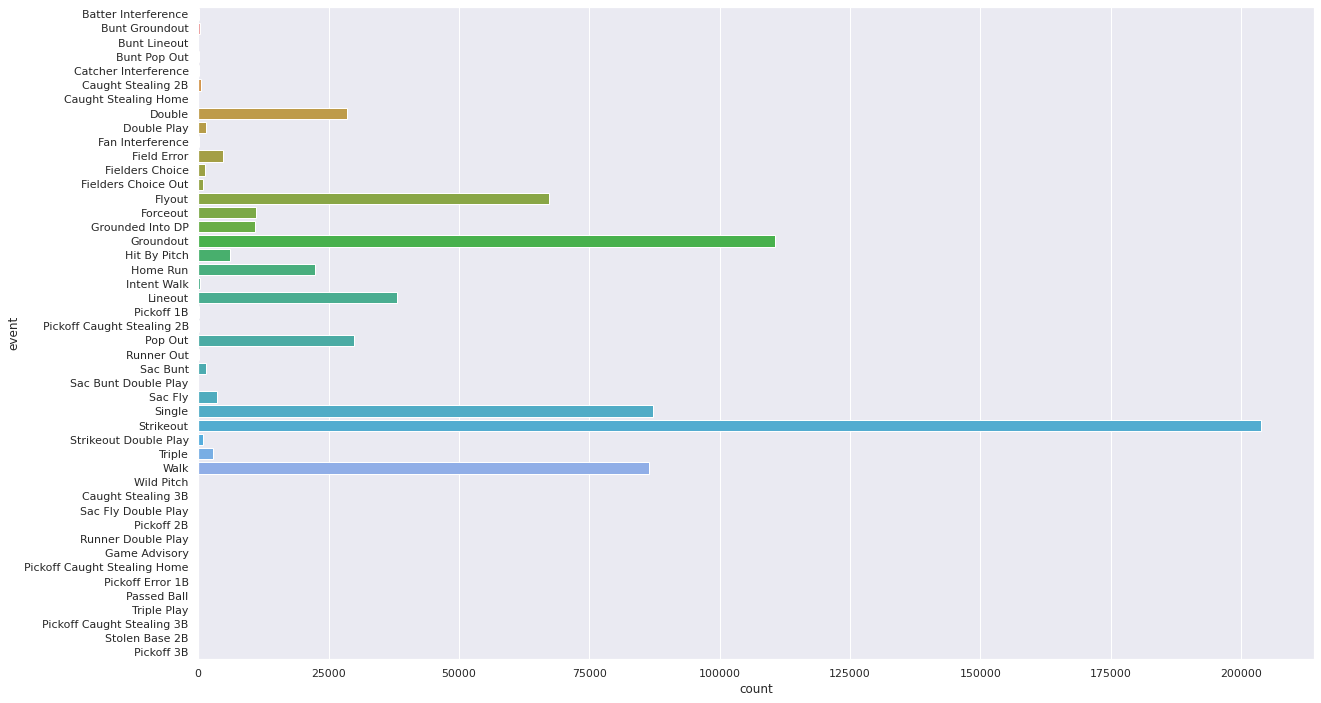

In [150]:
# Target variable: Graph the frequency of outcomes
sns.set_theme(context="notebook", style="darkgrid", palette="gist_ncar_r")

# Events
plt.figure(figsize=(20,12))
sns.countplot(y="event", data=df_main, orient="h")
plt.xscale("linear")
plt.show()

In [151]:
# Sort Events by Occurences
df_main.groupby("event").event.count().sort_values(ascending=False)

event
Strikeout                       203797
Groundout                       110503
Single                           87245
Walk                             86506
Flyout                           67275
Lineout                          38074
Pop Out                          29822
Double                           28475
Home Run                         22445
Forceout                         11065
Grounded Into DP                 10862
Hit By Pitch                      6072
Field Error                       4663
Sac Fly                           3693
Triple                            2798
Sac Bunt                          1471
Double Play                       1419
Fielders Choice                   1358
Fielders Choice Out                951
Strikeout Double Play              910
Caught Stealing 2B                 498
Intent Walk                        417
Bunt Groundout                     364
Catcher Interference               216
Batter Interference                189
Bunt Pop Out       

### Mapped data: Lumping similar together
It is pretty clear that strikeout leads the way followed by ground, single, and walk. However, we can use our baseball knowledge to better make sense of which catrgories are similar. Since some events are relatively low, we will combine them together to increase the likelihood that our model can predict the "lumped" together `event`. 

Thus, combining the data above and knowledge of baseball, we get the following six outcomes for our target variable
- Non-HR Hit <- Single, Double, Triple
- HR < - Home Run
- Defensive Out <- Groundout, Flyout, Lineout, Pop Out, Forceout, Grounded Into DP, Double Play, Bunt Groundout, Fielders Choice, Fielders Choice Out, Bunt Lineout, Bunt Pop Out, Triple Play
- Strikeout <- Strikeout, Strikeout Double Play
- Walk <- Walk, Hit by Pitch, Intent Walk
- Sacrifice <- Sac Fly, Sac Bunt, Sac Fly Double Play, Sac Bunt Double Play
- Other <- Field Error, Catcher Interference, Batter Interference, Fan Interference

Sacrifice plays are an interesting subcategory because the rely on the presence and location of baserunners, the score of the game, and the prowress of the batter. Sacrifice events ($n = 5208$) such as:
- Sac Fly
- Sac Bunt
- Sac Fly Double Play
- Sac Bunt Double Play

will be scruitinzed carefully due to the fact these are not registered statistically as at bats. Furthermore, it will be intriguing to see how `pitch_type`, a charactristic of the pitcher, will relate to this play that is largely guided by factors external to the pitchers decision to throw a a specific pitch.

Similarly, plays that do not require the interaction between the pitcher and the batter are also dropped. For example, the [pickoff play](https://en.wikipedia.org/wiki/Pickoff) involves the pitcher throwing to a fellow defensive player to get an out. This does not require the interaction between the pitcher and the batter. Therefore the following inter-pitch events ($n = 801$) are also dropped: 
- Caught Stealing 2B
- Pickoff Caught Stealing 2B
- Pickoff 1B
- Caught Stealing Home
- Caught Stealing 3B
- Pickoff 2B
- Pickoff Caught Stealing Home
- Wild Pitch
- Pickoff 3B
- Pickoff Caught Stealing 3B
- Passed Ball
- Pickoff Error 1B
- Stolen Base 2B
- Runner Double Play
- Runner Out



In [207]:
# Create new dataframe "df_prepped"
df_prepped = df_main.reset_index(drop=True)

# List of non-at bat events
non_at_bat_subs_lst = \
["Caught Stealing 2B", "Pickoff Caught Stealing 2B", "Pickoff 1B", 
 "Caught Stealing Home", "Caught Stealing 3B", "Pickoff 2B", 
 "Pickoff Caught Stealing Home", "Wild Pitch", "Pickoff 3B", 
 "Pickoff Caught Stealing 3B", "Passed Ball", "Pickoff Error 1B", 
 "Stolen Base 2B", "Runner Double Play", "Runner Out"]

# Drop non-at bat events
mask = df_prepped.event.isin(non_at_bat_subs_lst)
df_prepped.event.iloc[mask] = np.nan
df_prepped = df_prepped[df_prepped["event"].notna()]

# Preview the loss of rows
df_prepped.shape

(720975, 17)

Roughly 901 rows (0.13 %) were dropped when the non-at bat scenarios were removed from the dataset. These seem a little low because Bill James [reports](https://www.billjamesonline.com/legally_stolen_bases/#:~:text=The%202019%20Philadelphia%20Phillies%20allowed%2066%20stolen%20bases%2C,is%20the%20starting%20point%20of%20our%20process%20here.) that the Philadelphia Phillies caught 50 runners stealing bases in 2019. Expanded to all 30 teams that would mean 1500 runners were caught stealing, which almost doubles the amount here. Finding caught stealing stats proves to be difficult.

In [208]:
# Organize the subevents into lists
## Non-Hit HR
non_hit_HR_subs_lst = ["Single", "Double", "Triple"]
## HR
HR_subs_lst = ["Home Run"]
## Defensive Out
defensive_out_subs_lst =\
 ["Groundout", "Flyout", "Lineout", "Pop Out",  "Forceout", "Grounded Into DP", 
  "Double Play","Bunt Groundout", "Fielders Choice", "Fielders Choice Out", 
  "Bunt Lineout", "Bunt Pop Out", "Triple Play"]
## Strikeout
strikeout_subs_lst = ["Strikeout", "Strikeout Double Play"]
## Walk
walk_subs_lst = ["Walk", "Hit By Pitch", "Intent Walk"]
## Sacrifice
sac_subs_lst = ["Sac Fly", "Sac Bunt", 
                "Sac Fly Double Play", "Sac Bunt Double Play"]
## Other
other_subs_lst = ["Field Error", "Catcher Interference", "Batter Interference",
                  "Fan Interference"]
# Create empty series for updated events
event_new = pd.Series(index=range(len(df_main)))

# Map subcategories of event
relev_events = ["Non-HR Hit", "HR", "Def Out", "Strikeout", "Walk", "Sacrifice",
                "Other"]

# Use boolean masks to map the data accordingly
## Non-Hit HR
mask = df_main.event.isin(non_hit_HR_subs_lst)
event_new.iloc[mask] = relev_events[0]
## HR
mask = df_main.event.isin(HR_subs_lst)
event_new.iloc[mask] = relev_events[1]
## Defensive Out
mask = df_main.event.isin(defensive_out_subs_lst)
event_new.iloc[mask] = relev_events[2]
## Strikeout
mask = df_main.event.isin(strikeout_subs_lst)
event_new.iloc[mask] = relev_events[3]
## Walk
mask = df_main.event.isin(walk_subs_lst)
event_new.iloc[mask] = relev_events[4]
## Sacrifice
mask = df_main.event.isin(sac_subs_lst)
event_new.iloc[mask] = relev_events[5]
## Other
mask = df_main.event.isin(other_subs_lst)
event_new.iloc[mask] = relev_events[-1]

# Add event_new to dataframe 
df_prepped.insert(0, "event_new", event_new)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


From a previous iteration of the ML model, we know that `code` is an unfair feature to use because it effectively records what happens after the pitch is thrown. Since the objective is predict what pitches and scenarios lead to the various events, `code` is dropped from the dataframe.

In [209]:
# Drop "code"
df_prepped = df_prepped.drop(axis=1, columns=["code"])

# Also, drop the un-lumped "event", "first_name", "last_name", "pitcher_id", 
# and "ab_id" columns. "event_new" will be the new target variable and "ab_id"
# is not useful 
df_prepped = df_prepped.drop(axis=1, columns=["event", "pitcher_id", "ab_id", 
                                              "first_name", "last_name"])

In [210]:
df_prepped.head()

,event_new,start_speed,end_speed,pitch_type,b_score,b_count,s_count,outs,pitch_num,inning,p_score,p_throws
0,Def Out,88.8,80.7,FF,0.0,0,0,0,1,1,0,R
1,Def Out,89.9,81.8,FF,0.0,0,0,1,1,1,0,R
2,Def Out,85.7,79.6,SL,0.0,0,0,1,2,1,0,R
3,Def Out,85.4,78.5,CH,0.0,0,1,1,3,1,0,R
4,Def Out,84.6,77.6,CH,0.0,1,1,1,4,1,0,R


### Un-mapped data: Dropping unrelevant columns
After viewing the most common events, drop all rows  where the number of events is less than "Fielders Choice" 

This is an alternative strategy that can be used if one is only interested the most prevalent events.

In [ ]:
# Count the number of events that end in "Fielders Choice"
event_count = df_main.groupby(by="event").count().iloc[:,0]
event_count = event_count[event_count >= event_count["Fielders Choice"]]
# Collect the relevent columns
relevant_events = event_count.index.to_list()
# Create dataframe filtered by events that occured as much or greater than
# "Fielders Choice"
filter_mask = df_main.event.isin(relevant_events)
df_event_edit = df_main.loc[filter_mask]
# Preview the edited size
df_event_edit.shape

(717543, 17)

In [ ]:
# Correct to numeric
df_event_edit["s_count"] = df_event_edit.s_count.astype("int64")
df_event_edit["b_count"] = df_event_edit.b_count.astype("int64")
df_event_edit["outs"] = df_event_edit.outs.astype("int64")
df_event_edit["b_score"] = df_event_edit.b_score.astype("int64")
df_event_edit["p_score"] = df_event_edit.p_score.astype("int64")
# Correct to categorical
df_event_edit["inning"] = df_event_edit.inning.astype("category")
df_event_edit["p_throws"] = df_event_edit.p_throws.astype("category")
# Preview data types
df_event_edit.shape

In [ ]:
# Drop first and names from dataframe
df_event_edit.drop(columns=["last_name", "first_name"], axis=1, inplace=True)
# Export the dataframe to a .csv
df_event_edit.to_csv("df_event_edit.csv", index=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Model with sklearn

### Feature Engineering
Build features to help model with predictions

In [211]:
# Create a feature score_delta that relates the score of the game relative to pitcher
df_prepped["score_delta"] = df_prepped.p_score - df_prepped.b_score

In [231]:
# Export to csv
df_prepped.to_csv("df_prepped.csv", sep=",", index=False)

# Preview datatype
df_prepped.dtypes

### Encode categorical variables
There are several categorical variables in this dataset including the target variable, "event." For the ML algorithms to prcesss them appropriately, they need to be encoded as numeric values. Further guidance on incorporating categorical variables into ML models was gleaned from [Frank and Hall (2001)](https://www.cs.waikato.ac.nz/~eibe/pubs/ordinal_tech_report.pdf). 

Target Variable: `event_new`

To use `sklearn` we will need to apply an encoder to ensure that the target is recorded as numerical information instead of text

The `sklearn` [`label_encoder()`](https://sklearn.org/modules/generated/sklearn.preprocessing.LabelEncoder.html#:~:text=sklearn.preprocessing%20.LabelEncoder%20%C2%B6%20%20%20fit%20%28y%29%20,of%20this%20estimator.%20%201%20more%20rows%20) works well for this purpose. 

In [213]:
from sklearn.preprocessing import LabelEncoder
# Instantiate the encoder
target_encoder_le = LabelEncoder()

# Fit and transform the encoder to the target variable
## Separate target variable from explanatory features
y = df_prepped.iloc[:,0]
## Apply encoder
y = target_encoder_le.fit_transform(y.astype(str))

Features: All variables that are not the target

Just like the target variable, the categorical variables from the explanatory data (i.e. features) will need to transformed with encoding.

In [215]:
# Instantiate the encoder
explanatory_encoder_le = LabelEncoder()

# Fit and transform the encoder to the explanatory variable
## Separate explanatory variables from the target variable
X = df_prepped.iloc[:, 1:].values

## Apply encoder
### pitch_type
X[:,2] = explanatory_encoder_le.fit_transform(X[:,2].astype(str))
### b_count
X[:,4] = explanatory_encoder_le.fit_transform(X[:,4].astype(str))
### s_count
X[:,5] = explanatory_encoder_le.fit_transform(X[:,5].astype(str))
### p_throws
X[:,10] = explanatory_encoder_le.fit_transform(X[:,10].astype(str))

Data Type corrections: last chance to confirm data types are correct

### Establish response and features separately

- iteration 1.0: H2O only
- iteration 2.0: RF Classifier with max depth at 2 and seed at 42 (`code`) dropped as discussed with Josh
-iteration 2.1: grid search across parameters for RF

In [216]:
# Split dataframe into test and train sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Train-test-split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=0)


In [219]:
from sklearn.ensemble import RandomForestClassifier
# Intantiate classifier
RF_clf = RandomForestClassifier(max_depth=2, random_state=0)
# Fit Classifier
RF_clf.fit(X_train, y_train)
# Create Predictions
y_pred = RF_clf.predict(X_test)


In [221]:
# Estimate perfromance metrics
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_test, y_pred))

Accuracy:  0.38547799854363884


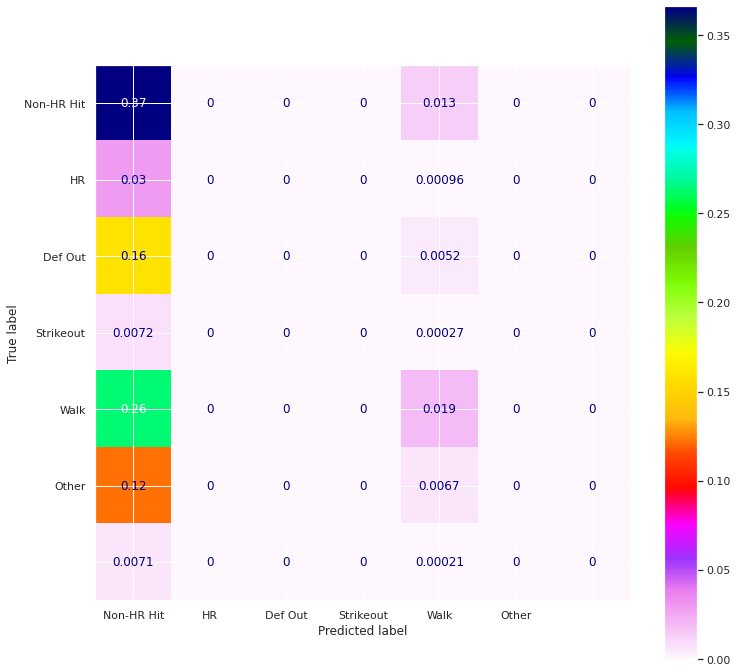

In [229]:
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(RF_clf, X_test, y_test,
                      cmap="gist_ncar_r",
                      display_labels=relev_events,
                      normalize="all",
                      ax=ax)
plt.show()
plt.savefig("figures/confusion_matrix_RF.png", dpi=300)

## Model with H$_2$O
As an alternative to sklearn, we can use H$_2$O api lirbary to conduct a similar model

Install H2O for modeling

In [230]:
!pip install h2o

     |████████████████████████████████| 164.8MB 79kB/s 
  Created wheel for h2o: filename=h2o-3.32.1.2-py2.py3-none-any.whl size=164848811 sha256=b187e29e3d3ebbe5baaef50fb9f84a8ca55edd2418d341d54c43e1b8c76fee6a
  Stored in directory: /root/.cache/pip/wheels/37/b6/c7/c1cfdcd471d476b2b5129f4d27a0fd89043858ee74eda7ee7a
Successfully built h2o


In [232]:
import h2o
from h2o.estimators import H2ORandomForestEstimator
# Instantiate h2o in workspace
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.10" 2021-01-19; OpenJDK Runtime Environment (build 11.0.10+9-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.10+9-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdelbw2ee
  JVM stdout: /tmp/tmpdelbw2ee/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdelbw2ee/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.2
H2O_cluster_version_age:,2 days
H2O_cluster_name:,H2O_from_python_unknownUser_jios4y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.180 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"accepting new members, healthy"


In [235]:
feat_list = df_prepped.iloc[:,1:].columns.to_list()

In [239]:
# Establish data to be modeled
data = h2o.import_file("df_prepped.csv")
# Target variable
response = "event_new"
# Features
data["score_delta"] = data["p_score"] - data["b_score"]
feats = feat_list+["score_delta"]

Parse progress: |█████████████████████████████████████████████████████████| 100%


Train-test-split the data into training and testing dataframes

In [240]:
# Split data into train and testing
train, test = data.split_frame(ratios=[0.8])

Establish RF Classifier Model

On first attempt, this model took 41 min to run.

After running the model, save it to `model_path`. This will now be in the Colab folder under "mdl_event_edit"

In [241]:
# Define model
model = H2ORandomForestEstimator(max_depth=5, nfolds=10, seed=42)

# Train model
model.train(x=feats, y=response, training_frame=train)
model_path = h2o.save_model(model=model, path="mdl_event_edit", force=True)

drf Model Build progress: |███████████████████████████████████████████████| 100%


Examine Performance


In [242]:
# Model performance
performance = model.model_performance(test_data=test)

print(performance)


ModelMetricsMultinomial: drf
** Reported on test data. **

MSE: 0.5244604220836859
RMSE: 0.7241963974528498
LogLoss: 1.394454985480229
Mean Per-Class Error: 0.7945646081392163
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,45803.0,0.0,0.0,0.0,6887.0,1898.0,0.160933,"8,785 / 54,588"
1,3844.0,0.0,0.0,0.0,521.0,193.0,1.000000,"4,558 / 4,558"
2,19864.0,0.0,0.0,0.0,2926.0,790.0,1.000000,"23,580 / 23,580"
3,846.0,0.0,0.0,0.0,147.0,47.0,1.000000,"1,040 / 1,040"
4,29884.0,0.0,0.0,0.0,9413.0,1261.0,0.767913,"31,145 / 40,558"
5,13050.0,0.0,0.0,0.0,2619.0,3017.0,0.838542,"15,669 / 18,686"
6,113291.0,0.0,0.0,0.0,22513.0,7206.0,0.592805,"84,777 / 143,010"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.407195
1,2,0.678750
2,3,0.859206
3,4,0.960863
4,5,0.992749
5,6,1.000000


Performance for each fold and a verbose summary of other metrics

In [243]:
model.feature_frequencies

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1619944967047_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,300.0,135092.0,5.0,5.0,5.0,20.0,32.0,31.163334




ModelMetricsMultinomial: drf
** Reported on train data. **

MSE: 0.524773527673836
RMSE: 0.7244125396994698
LogLoss: 1.3947110793864854
Mean Per-Class Error: 0.7950591036828754
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,181947.0,0.0,0.0,0.0,27960.0,7415.0,0.162777,"35,375 / 217,322"
1,14897.0,5.0,0.0,0.0,2213.0,772.0,0.999720,"17,882 / 17,887"
2,79738.0,0.0,0.0,0.0,12040.0,3160.0,1.000000,"94,938 / 94,938"
3,3478.0,0.0,0.0,0.0,537.0,132.0,1.000000,"4,147 / 4,147"
4,120318.0,0.0,0.0,0.0,38752.0,5079.0,0.763922,"125,397 / 164,149"
5,52423.0,0.0,0.0,0.0,10289.0,11597.0,0.843935,"62,712 / 74,309"
6,452801.0,5.0,0.0,0.0,91791.0,28155.0,0.594413,"340,451 / 572,752"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.405587
1,2,0.679273
2,3,0.858061
3,4,0.961556
4,5,0.992765
5,6,1.000000



ModelMetricsMultinomial: drf
** Reported on cross-validation data. **

MSE: 0.524803709005949
RMSE: 0.72443337099139
LogLoss: 1.3945807271641213
Mean Per-Class Error: 0.7950512795795007
AUC: NaN
AUCPR: NaN
Multinomial auc values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).
Multinomial auc_pr values: Table is not computed because it is disabled (model parameter 'auc_type' is set to AUTO or NONE) or due to domain size (maximum is 50 domains).

Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,182700.0,1.0,1.0,0.0,27083.0,7537.0,0.159312,"34,622 / 217,322"
1,14940.0,1.0,0.0,0.0,2139.0,807.0,0.999944,"17,886 / 17,887"
2,80108.0,0.0,0.0,0.0,11614.0,3216.0,1.000000,"94,938 / 94,938"
3,3513.0,0.0,0.0,0.0,507.0,127.0,1.000000,"4,147 / 4,147"
4,121320.0,0.0,0.0,0.0,37724.0,5105.0,0.770184,"126,425 / 164,149"
5,52271.0,0.0,0.0,0.0,10213.0,11825.0,0.840867,"62,484 / 74,309"
6,454852.0,2.0,1.0,0.0,89280.0,28617.0,0.594502,"340,502 / 572,752"



Top-6 Hit Ratios: 


,k,hit_ratio
0,1,0.405498
1,2,0.678987
2,3,0.858344
3,4,0.961551
4,5,0.992760
5,6,1.000000



Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid,cv_6_valid,cv_7_valid,cv_8_valid,cv_9_valid,cv_10_valid
0,accuracy,0.40549937,0.0021332395,0.40444803,0.40695015,0.4062817,0.40654254,0.40776378,0.40444994,0.40661338,0.40683225,0.40473238,0.40037966
1,auc,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,aucpr,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,err,0.5945006,0.0021332395,0.59555197,0.5930499,0.5937183,0.59345746,0.5922362,0.59555006,0.5933866,0.5931678,0.59526765,0.59962034
4,err_count,34050.2,160.60774,34062.0,33961.0,33950.0,33852.0,34037.0,34181.0,33934.0,34033.0,34063.0,34429.0
5,logloss,1.3945813,0.0028661175,1.3929193,1.3880005,1.3961605,1.394834,1.3940411,1.3940126,1.3974584,1.3936613,1.3975782,1.3971469
6,max_per_class_error,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,mean_per_class_accuracy,0.20494916,5.5803626E-4,0.20446391,0.20446157,0.20448679,0.20578167,0.20554262,0.2045857,0.20538,0.20563065,0.20466521,0.20449351
8,mean_per_class_error,0.79505086,5.5803626E-4,0.7955361,0.7955384,0.7955132,0.79421836,0.7944574,0.79541427,0.79462004,0.79436934,0.79533476,0.7955065
9,mse,0.5248036,7.174183E-4,0.52465063,0.5232856,0.5249154,0.5244956,0.5244129,0.5249602,0.5253434,0.52456164,0.5255566,0.5258538



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_classification_error,training_auc,training_pr_auc
0,,2021-05-02 09:08:51,21 min 28.058 sec,0.0,NaN,NaN,NaN,NaN,NaN
1,,2021-05-02 09:08:53,21 min 29.802 sec,1.0,0.723530,1.397393,0.594036,NaN,NaN
2,,2021-05-02 09:08:55,21 min 31.578 sec,2.0,0.723196,1.396826,0.594018,NaN,NaN
3,,2021-05-02 09:09:00,21 min 37.531 sec,5.0,0.724132,1.397415,0.596225,NaN,NaN
4,,2021-05-02 09:09:05,21 min 41.808 sec,7.0,0.724052,1.396430,0.595684,NaN,NaN
5,,2021-05-02 09:09:09,21 min 46.124 sec,9.0,0.724083,1.395935,0.595656,NaN,NaN
6,,2021-05-02 09:09:13,21 min 50.420 sec,11.0,0.723992,1.395337,0.595687,NaN,NaN
7,,2021-05-02 09:09:17,21 min 54.538 sec,13.0,0.723730,1.394408,0.594813,NaN,NaN
8,,2021-05-02 09:09:22,21 min 59.343 sec,16.0,0.724024,1.394787,0.595323,NaN,NaN
9,,2021-05-02 09:09:26,22 min 3.468 sec,18.0,0.724119,1.394871,0.594985,NaN,NaN



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,b_count,128168.164062,1.000000,0.441139
1,pitch_num,87504.492188,0.682732,0.301180
2,s_count,41869.820312,0.326679,0.144111
3,pitch_type,15648.855469,0.122096,0.053861
4,start_speed,6553.925781,0.051135,0.022558
5,end_speed,3747.200928,0.029237,0.012897
6,inning,2438.934326,0.019029,0.008395
7,score_delta,1566.135498,0.012219,0.005390
8,b_score,1352.155518,0.010550,0.004654
9,outs,997.066772,0.007779,0.003432


<bound method ModelBase.feature_frequencies of >

Visualize performance\
*The eighteenth row indicates the total count*

According to the [documentation](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/performance-and-prediction.html#confusion-matrix) for CMs using H2O, this model did really well with predicting strikeouts, it only missed 3% of the classifications. This model did not do well at all with predicting small classes reinforcing the idea that we map some of them to other classes. Likely, the best method will be to map classes into:
- Hit
- HR
- Defensive Out
- Strikeout
- Walk


In [244]:
# Confusion Matrix
cm = model.confusion_matrix(test)
cm


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,Def Out,HR,Non-HR Hit,Other,Strikeout,Walk,Error,Rate
0,45803.0,0.0,0.0,0.0,6887.0,1898.0,0.160933,"8,785 / 54,588"
1,3844.0,0.0,0.0,0.0,521.0,193.0,1.000000,"4,558 / 4,558"
2,19864.0,0.0,0.0,0.0,2926.0,790.0,1.000000,"23,580 / 23,580"
3,846.0,0.0,0.0,0.0,147.0,47.0,1.000000,"1,040 / 1,040"
4,29884.0,0.0,0.0,0.0,9413.0,1261.0,0.767913,"31,145 / 40,558"
5,13050.0,0.0,0.0,0.0,2619.0,3017.0,0.838542,"15,669 / 18,686"
6,113291.0,0.0,0.0,0.0,22513.0,7206.0,0.592805,"84,777 / 143,010"


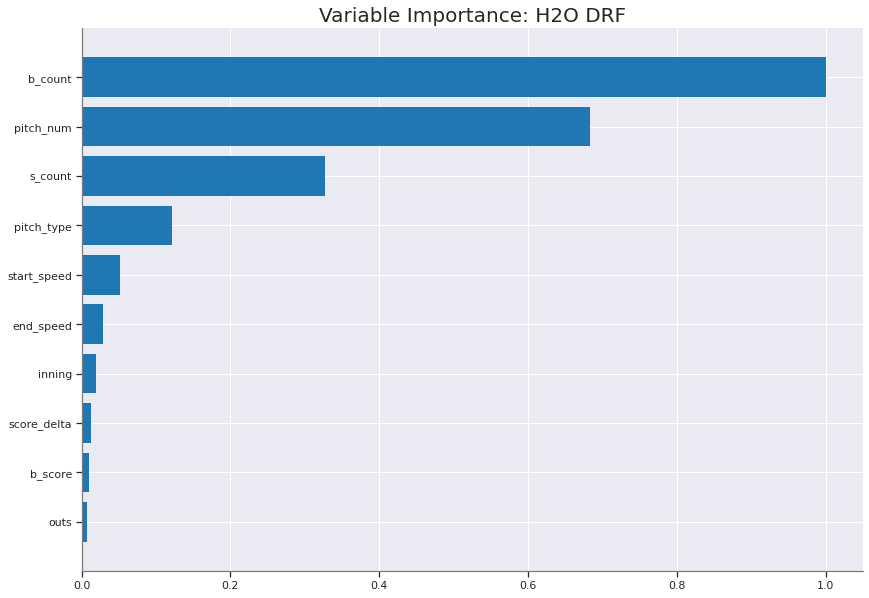

In [245]:
# Variable Importance plot
model.varimp_plot()